# Test of PCA in Pipeline For Training Models
### Leonard Moen | December 5th 2022

In [229]:
import pandas as pd
import numpy as np
import importlib
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import lazypredict

from lazypredict.Supervised import LazyClassifier
from sklearn.linear_model import  Perceptron
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, label_binarize #Standardization and conversion of categorical labels to binary representation
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA

from sklearn.naive_bayes import BernoulliNB
from sklearn.pipeline import Pipeline

import LoadKinecalFunctions
from LoadKinecalFunctions import *
importlib.reload(LoadKinecalFunctions)
from const import User, Exercise
import models
from models import *
importlib.reload(models)
importlib.reload(sklearn.linear_model)
importlib.reload(lazypredict)

<module 'lazypredict' from 'c:\\Users\\Leonard\\anaconda3\\envs\\ELEC872\\lib\\site-packages\\lazypredict\\__init__.py'>

In [319]:
user = 0
excerciseList = [Exercise.QSECFS, Exercise.QSEOFS, Exercise.STS, Exercise.TS]

QSClosedDf = readKinecalFiles(excerciseList[0],user) 
QSOpenDf = readKinecalFiles(excerciseList[1],user) 
SemiTandemDf = readKinecalFiles(excerciseList[2],user) 
TandemDf = readKinecalFiles(excerciseList[3],user) 

### Seperate X and Y Dataframes

In [320]:
yDf = QSClosedDf.iloc[:,0:9]
yDf = yDf.drop(columns='movement')
yDf['part_id'] = yDf['part_id'].apply(pd.to_numeric)

QSClosedXDf =QSClosedDf.iloc[: , 9:-1]
QSOpenXDf =QSOpenDf.iloc[: ,9:-1]
SemiTandemXDf =SemiTandemDf.iloc[: ,9:-1]
TandemXDf =TandemDf.iloc[: ,9:-1]

print(yDf)

    part_id group sex  height  weight   BMI recorded_in_the_lab  \
0        10    HA   m    1.85   77.00 22.50                   1   
1       100    NF   f    1.55   82.50 34.30                   1   
2        11    HA   f    1.57   51.50 20.90                   1   
3        12    HA   m    1.64   68.50 25.50                   1   
4        13    HA   m    1.78   85.00 26.80                   1   
..      ...   ...  ..     ...     ...   ...                 ...   
85       84   FHm   f    1.56   60.00 24.70                   0   
86       87   FHs   f    1.60   77.10 30.10                   0   
87        9    HA   m    1.69   75.00 26.30                   1   
88       92    NF   m    1.83   97.00 29.00                   0   
89       96   FHs   m    1.78   81.20 25.60                   0   

   clinically_at_risk  
0                   0  
1                   0  
2                   0  
3                   0  
4                   0  
..                ...  
85                  0  
86 

### Replace Missing Values

In [321]:
QSClosedXDf = replaceMissingValues(QSClosedXDf,yDf)
QSOpenXDf = replaceMissingValues(QSOpenXDf,yDf)
SemiTandemXDf = replaceMissingValues(SemiTandemXDf,yDf)
TandemXNDf = replaceMissingValues(TandemXDf,yDf)

[ 2 14 15]
[ 2 17 29 34 71]
[ 2 14 17 31 33 60 66]
[13 14 17 29 31 33 36 37 55 60 66 74 77]


### Combine Excercises Into One Dataset

In [331]:
print(QSClosedXDf.shape,QSOpenXDf.shape,SemiTandemXDf.shape,TandemXDf.shape)

### NORMALIZATION BEFORE FEATURE CONCATENATION
# QSClosedXNormDf = datasetNormalization(QSClosedXDf)
# QSOpenXNormDf = datasetNormalization(QSOpenXDf)
# SemiTandemXNormDf = datasetNormalization(SemiTandemXDf)
# TandemXNormDf = datasetNormalization(TandemXDf)
# combinedXNormDf = pd.concat([QSClosedXNormDf,QSOpenXNormDf,SemiTandemXNormDf,TandemXNormDf],axis=1)

###NORMALIZATION AFTER FEATURE CONCATENATION
combinedXDf = pd.concat([QSClosedXDf,QSOpenXDf,SemiTandemXDf,TandemXDf],axis=1)
combinedXNormDf = datasetNormalization(combinedXDf)

### Make Index of X dataframe part_id so that it corresponds with test set loaded in later
combinedXNormDf['part_id'] = yDf.part_id.values

combinedXNormDf =combinedXNormDf.set_index('part_id')
print(combinedXNormDf.shape)

(90, 16) (90, 16) (90, 16) (90, 16)
(90, 64)


### Add Labels for Binary Case

In [332]:
yTrain = binaryLabelRemapping(yDf,True)


### Seperate Into Training and Testing Sets

In [333]:
yTest = pd.read_csv('yTest.csv')
# xTest = pd.read_csv('xTest.csv')
# xTrain = pd.read_csv('xTrain.csv')
# yTrain = pd.read_csv('yTrain.csv')
# xTest = xTest.set_index(pd.Index(yTest['part_id'].values))
# xTrain = xTrain.set_index(pd.Index(yTrain['part_id'].values))

yTrain = yTrain.loc[~yTrain.part_id.isin(yTest.part_id.values)]
xTrain = combinedXNormDf.loc[combinedXNormDf.index.isin(yTrain.part_id.values)]
xTest = combinedXNormDf.loc[~combinedXNormDf.index.isin(yTrain.part_id.values)]

yTest = yTest.sort_values(by=['part_id'])
yTrain = yTrain.sort_values(by=['part_id'])
xTrain = xTrain.sort_index()
xTest = xTest.sort_index()
# xTest.to_csv('test.csv')
# yTest.to_csv('test2.csv')
#xTrain, xTest, yTrain, yTest = train_test_split(combinedXNormDf, yDf, test_size=0.2, random_state=42)

le = LabelEncoder()

yTrainBinary = binaryLabelRemapping(yTrain, True)
yTestBinary = binaryLabelRemapping(yTest, True)

yTrain_bin_orig = yTrainBinary
yTest_bin_orig = yTestBinary

yDf_bin = binaryLabelRemapping(yDf, True)

X = np.asarray(combinedXNormDf)
y_bin = np.asarray(le.fit_transform(yDf_bin.label_binary.values))


xTrain = np.asarray(xTrain)
xTest= np.asarray(xTest)
#convert to numpy array
yTrainBinary = np.asarray(le.fit_transform(yTrainBinary.label_binary.values))
yTestBinary = np.asarray(le.fit_transform(yTestBinary.label_binary.values))

print(yTest)
# xTrain = X
# yTrainBinary = y_bin

    part_id group sex  height  weight   BMI  recorded_in_the_lab  \
12        5    HA   m    1.75   70.00 22.90                    1   
4        10    HA   m    1.85   77.00 22.50                    1   
15       13    HA   m    1.78   85.00 26.80                    1   
8        19    HA   m    1.78   79.00 24.90                    1   
14       20    HA   m    1.66   60.00 21.80                    1   
16       24    HA   f    1.57   73.00 29.60                    0   
6        40   FHs   m    1.90  102.50 28.40                    0   
2        48    NF   m    1.70   73.40 25.40                    0   
7        61    NF   m    1.73   65.30 21.80                    0   
3        68    NF   f    1.68   69.00 24.40                    0   
10       73    NF   m    1.78   69.80 22.00                    0   
13       87   FHs   f    1.60   77.10 30.10                    0   
1       300    HA   f    1.57   49.80 20.20                    0   
5       304   FHs   f    1.63   60.30 22.70     

### Apply Lazy Classifier To Get Pipeline of Model

In [334]:
lazyclass = LazyClassifier(verbose=0, ignore_warnings=False, custom_metric=None)
print(yTrainBinary)
print(lazyclass.classifiers)
scores, predictions = lazyclass.fit(np.asarray(xTrain), np.asarray(xTest), yTrainBinary, yTestBinary)
print(scores)
modelDict = lazyclass.provide_models(xTrain, xTest, yTrainBinary, yTestBinary)

[1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 0 0 0 1 1 1 1 0 1
 0 1 0 0 1 1 1 1 1 1 0 0 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 0 1 1]
all


 33%|███▎      | 9/27 [00:00<00:00, 44.60it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)


100%|██████████| 27/27 [00:00<00:00, 63.83it/s]

StackingClassifier model failed to execute
__init__() missing 1 required positional argument: 'estimators'
                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
BernoulliNB                        0.61               0.61     0.61      0.63   
QuadraticDiscriminantAnalysis      0.78               0.60     0.60      0.72   
LinearDiscriminantAnalysis         0.50               0.59     0.59      0.51   
GaussianNB                         0.50               0.59     0.59      0.51   
SGDClassifier                      0.61               0.55     0.55      0.62   
NearestCentroid                    0.50               0.53     0.53      0.52   
BaggingClassifier                  0.67               0.52     0.52      0.64   
SVC                                0.72               0.50     0.50      0.61   
DummyClassifier                    0.72               0.50     0.50      0.61   
Ca

In [335]:
#iterate through scores and find model with highest balanced accuracy
classifiers = scores.index.tolist()
balAccs = scores['Balanced Accuracy']
bestModel = max(zip(classifiers, balAccs), key=lambda x: x[1])
#pipe = modelDict[bestModel[0]]
pipe = modelDict["Perceptron"]
print(bestModel)

('BernoulliNB', 0.6076923076923078)


### Tune Perceptron Without PCA

In [336]:
#Perform grid search on best model
tuning_params = [{
    "classifier__penalty": ['elasticnet'],
    "classifier__l1_ratio": [0.48, 0.49, 0.5, 0.51, 0.52],
    "classifier__alpha": [0.09, 0.1, 0.11],
    "classifier__tol": [5e-6],
    "classifier__eta0": [6e-5, 1e-4, 1e-3],
    "classifier__early_stopping": [False],
    "classifier__class_weight": [None],
    "classifier__warm_start": [True]
}]

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(pipe, tuning_params, 
                    cv=skf.split(xTrain,yTrainBinary), scoring='accuracy', 
                    verbose=2, refit=True)

grid.fit(xTrain,yTrainBinary)

best_model = grid.best_estimator_
optimal_params = grid.best_params_

Fitting 5 folds for each of 45 candidates, totalling 225 fits
[CV] END classifier__alpha=0.09, classifier__class_weight=None, classifier__early_stopping=False, classifier__eta0=6e-05, classifier__l1_ratio=0.48, classifier__penalty=elasticnet, classifier__tol=5e-06, classifier__warm_start=True; total time=   0.0s
[CV] END classifier__alpha=0.09, classifier__class_weight=None, classifier__early_stopping=False, classifier__eta0=6e-05, classifier__l1_ratio=0.48, classifier__penalty=elasticnet, classifier__tol=5e-06, classifier__warm_start=True; total time=   0.0s
[CV] END classifier__alpha=0.09, classifier__class_weight=None, classifier__early_stopping=False, classifier__eta0=6e-05, classifier__l1_ratio=0.48, classifier__penalty=elasticnet, classifier__tol=5e-06, classifier__warm_start=True; total time=   0.0s
[CV] END classifier__alpha=0.09, classifier__class_weight=None, classifier__early_stopping=False, classifier__eta0=6e-05, classifier__l1_ratio=0.48, classifier__penalty=elasticnet, c

In [337]:
print(grid.best_score_)
print(grid.best_params_)

0.7361904761904763
{'classifier__alpha': 0.1, 'classifier__class_weight': None, 'classifier__early_stopping': False, 'classifier__eta0': 0.001, 'classifier__l1_ratio': 0.51, 'classifier__penalty': 'elasticnet', 'classifier__tol': 5e-06, 'classifier__warm_start': True}


### Train Perceptron with Best Parameters

In [338]:
print(grid.best_score_)
print(grid.best_params_)
clf = best_model

y_pred_bin = pipe.predict(xTest)

#map predictions back to original labels
y_pred_label = le.inverse_transform(y_pred_bin)
y_test_label = le.inverse_transform(yTestBinary)


0.7361904761904763
{'classifier__alpha': 0.1, 'classifier__class_weight': None, 'classifier__early_stopping': False, 'classifier__eta0': 0.001, 'classifier__l1_ratio': 0.51, 'classifier__penalty': 'elasticnet', 'classifier__tol': 5e-06, 'classifier__warm_start': True}


### Create Confusion Matrix for Non-PCA Perceptron

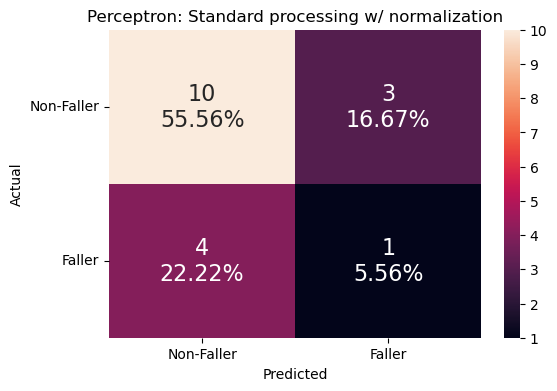

              precision    recall  f1-score   support

      Faller       0.25      0.20      0.22         5
  Non-Faller       0.71      0.77      0.74        13

    accuracy                           0.61        18
   macro avg       0.48      0.48      0.48        18
weighted avg       0.59      0.61      0.60        18



In [339]:
classes = ['Non-Faller', 'Faller']
cm_python = confusion_matrix(y_true=y_test_label, y_pred=y_pred_label, labels=classes)

plt.subplots(figsize=(6,4))

group_counts = ['{0:0.0f}'.format(value) for value in
                cm_python.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cm_python.flatten()/np.sum(cm_python)]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
df_cm_python = pd.DataFrame(cm_python)

sns.heatmap(df_cm_python, annot=labels, fmt='',annot_kws={"size": 16}, xticklabels=classes, yticklabels=classes) # font size
plt.title('Perceptron: Standard processing w/ normalization')
plt.xlabel('Predicted')
plt.ylabel('Actual') 
plt.yticks(rotation=0)
plt.show()

print(classification_report(y_true=y_test_label, y_pred=y_pred_label))

### Do PCA on Training Data

In [256]:
log = []
bestScore = 0
for num_components in range(1,64):
    pca = PCA(n_components=num_components) # Initialize a PLS object, specifying 10 components
    #pls = LinearDiscriminantAnalysis(n_components=num_components)
    pca.fit(xTrain, yTrainBinary) # Fit to the training data w/ binary label set
    #transformed_pls_data = pls.x_scores_ # Extract the computed components on the training data

    pca_X = pca.transform(xTrain)
    pca_xTest = pca.transform(xTest)

    lazyclass = LazyClassifier(verbose=0, ignore_warnings=False, custom_metric=None)
    scores, predictions = lazyclass.fit(np.asarray(pca_X), np.asarray(pca_xTest), yTrainBinary, yTestBinary)

    modelDict = lazyclass.provide_models(pca_X, pca_xTest, yTrainBinary, yTestBinary)
    #iterate through scores and find model with highest balanced accuracy
    pipe = modelDict["Perceptron"]
    #Perform grid search on best model
    tuning_params = [{
        "classifier__penalty": ['elasticnet'],
        "classifier__l1_ratio": [0.48, 0.49, 0.5, 0.51, 0.52],
        "classifier__alpha": [0.09, 0.1, 0.11],
        "classifier__tol": [5e-6],
        "classifier__eta0": [6e-5, 1e-4, 1e-3],
        "classifier__early_stopping": [False],
        "classifier__class_weight": [None],
        "classifier__warm_start": [True]
    }]

    #for num_components in range(7,64): # Iterate through the use of 3 to 100 components  (3,101)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid = GridSearchCV(pipe, tuning_params, 
                        cv=skf.split(pca_X,yTrainBinary), scoring='accuracy', 
                        verbose=0, refit=True)
    #print(pca_X.shape)
    #print(yTrainBinary.shape)
    grid.fit(pca_X,yTrainBinary)

    if grid.best_score_ > bestScore:
        bestScore = grid.best_score_
        bestComponents = num_components
        best_model = grid.best_estimator_
        optimal_params = grid.best_params_


 33%|███▎      | 9/27 [00:00<00:00, 52.63it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)


100%|██████████| 27/27 [00:00<00:00, 78.49it/s]


StackingClassifier model failed to execute
__init__() missing 1 required positional argument: 'estimators'


 33%|███▎      | 9/27 [00:00<00:00, 48.13it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)


100%|██████████| 27/27 [00:00<00:00, 71.43it/s]


StackingClassifier model failed to execute
__init__() missing 1 required positional argument: 'estimators'


 59%|█████▉    | 16/27 [00:00<00:00, 72.92it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)


100%|██████████| 27/27 [00:00<00:00, 74.59it/s]


StackingClassifier model failed to execute
__init__() missing 1 required positional argument: 'estimators'


 52%|█████▏    | 14/27 [00:00<00:00, 69.59it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)


100%|██████████| 27/27 [00:00<00:00, 76.92it/s]


StackingClassifier model failed to execute
__init__() missing 1 required positional argument: 'estimators'


 59%|█████▉    | 16/27 [00:00<00:00, 77.23it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)


100%|██████████| 27/27 [00:00<00:00, 76.70it/s]


StackingClassifier model failed to execute
__init__() missing 1 required positional argument: 'estimators'


 52%|█████▏    | 14/27 [00:00<00:00, 68.12it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)


100%|██████████| 27/27 [00:00<00:00, 73.97it/s]


StackingClassifier model failed to execute
__init__() missing 1 required positional argument: 'estimators'


 52%|█████▏    | 14/27 [00:00<00:00, 67.08it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)


100%|██████████| 27/27 [00:00<00:00, 74.18it/s]


StackingClassifier model failed to execute
__init__() missing 1 required positional argument: 'estimators'


 52%|█████▏    | 14/27 [00:00<00:00, 65.96it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)


100%|██████████| 27/27 [00:00<00:00, 75.42it/s]


StackingClassifier model failed to execute
__init__() missing 1 required positional argument: 'estimators'


 52%|█████▏    | 14/27 [00:00<00:00, 70.64it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)


100%|██████████| 27/27 [00:00<00:00, 75.63it/s]


StackingClassifier model failed to execute
__init__() missing 1 required positional argument: 'estimators'


 52%|█████▏    | 14/27 [00:00<00:00, 66.93it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)


100%|██████████| 27/27 [00:00<00:00, 75.21it/s]


StackingClassifier model failed to execute
__init__() missing 1 required positional argument: 'estimators'


 52%|█████▏    | 14/27 [00:00<00:00, 66.33it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)


100%|██████████| 27/27 [00:00<00:00, 75.00it/s]


StackingClassifier model failed to execute
__init__() missing 1 required positional argument: 'estimators'


 59%|█████▉    | 16/27 [00:00<00:00, 73.75it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)


100%|██████████| 27/27 [00:00<00:00, 74.59it/s]


StackingClassifier model failed to execute
__init__() missing 1 required positional argument: 'estimators'


 52%|█████▏    | 14/27 [00:00<00:00, 69.44it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)


100%|██████████| 27/27 [00:00<00:00, 74.18it/s]


StackingClassifier model failed to execute
__init__() missing 1 required positional argument: 'estimators'


 52%|█████▏    | 14/27 [00:00<00:00, 66.97it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)


100%|██████████| 27/27 [00:00<00:00, 74.59it/s]


StackingClassifier model failed to execute
__init__() missing 1 required positional argument: 'estimators'


 59%|█████▉    | 16/27 [00:00<00:00, 72.15it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)


100%|██████████| 27/27 [00:00<00:00, 74.18it/s]


StackingClassifier model failed to execute
__init__() missing 1 required positional argument: 'estimators'


 52%|█████▏    | 14/27 [00:00<00:00, 61.21it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)


100%|██████████| 27/27 [00:00<00:00, 70.22it/s]


StackingClassifier model failed to execute
__init__() missing 1 required positional argument: 'estimators'


 41%|████      | 11/27 [00:00<00:00, 50.62it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)


100%|██████████| 27/27 [00:00<00:00, 69.05it/s]


StackingClassifier model failed to execute
__init__() missing 1 required positional argument: 'estimators'


 44%|████▍     | 12/27 [00:00<00:00, 52.99it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)


100%|██████████| 27/27 [00:00<00:00, 70.31it/s]


StackingClassifier model failed to execute
__init__() missing 1 required positional argument: 'estimators'


 44%|████▍     | 12/27 [00:00<00:00, 55.83it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)


100%|██████████| 27/27 [00:00<00:00, 70.68it/s]


StackingClassifier model failed to execute
__init__() missing 1 required positional argument: 'estimators'


 52%|█████▏    | 14/27 [00:00<00:00, 60.19it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)


100%|██████████| 27/27 [00:00<00:00, 69.95it/s]


StackingClassifier model failed to execute
__init__() missing 1 required positional argument: 'estimators'


 44%|████▍     | 12/27 [00:00<00:00, 54.72it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)


100%|██████████| 27/27 [00:00<00:00, 71.24it/s]


StackingClassifier model failed to execute
__init__() missing 1 required positional argument: 'estimators'


 59%|█████▉    | 16/27 [00:00<00:00, 66.12it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)


100%|██████████| 27/27 [00:00<00:00, 71.43it/s]


StackingClassifier model failed to execute
__init__() missing 1 required positional argument: 'estimators'


 52%|█████▏    | 14/27 [00:00<00:00, 61.72it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)


100%|██████████| 27/27 [00:00<00:00, 71.43it/s]


StackingClassifier model failed to execute
__init__() missing 1 required positional argument: 'estimators'


 44%|████▍     | 12/27 [00:00<00:00, 52.28it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)


100%|██████████| 27/27 [00:00<00:00, 69.59it/s]


StackingClassifier model failed to execute
__init__() missing 1 required positional argument: 'estimators'


 44%|████▍     | 12/27 [00:00<00:00, 56.04it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)


100%|██████████| 27/27 [00:00<00:00, 71.43it/s]


StackingClassifier model failed to execute
__init__() missing 1 required positional argument: 'estimators'


 59%|█████▉    | 16/27 [00:00<00:00, 66.41it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)


100%|██████████| 27/27 [00:00<00:00, 70.31it/s]


StackingClassifier model failed to execute
__init__() missing 1 required positional argument: 'estimators'


 44%|████▍     | 12/27 [00:00<00:00, 55.40it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)


100%|██████████| 27/27 [00:00<00:00, 71.24it/s]


StackingClassifier model failed to execute
__init__() missing 1 required positional argument: 'estimators'


 44%|████▍     | 12/27 [00:00<00:00, 53.66it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)


100%|██████████| 27/27 [00:00<00:00, 67.84it/s]


StackingClassifier model failed to execute
__init__() missing 1 required positional argument: 'estimators'


 52%|█████▏    | 14/27 [00:00<00:00, 59.00it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)


100%|██████████| 27/27 [00:00<00:00, 68.70it/s]


StackingClassifier model failed to execute
__init__() missing 1 required positional argument: 'estimators'


 44%|████▍     | 12/27 [00:00<00:00, 52.28it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)


100%|██████████| 27/27 [00:00<00:00, 68.35it/s]


StackingClassifier model failed to execute
__init__() missing 1 required positional argument: 'estimators'


 52%|█████▏    | 14/27 [00:00<00:00, 59.00it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)


100%|██████████| 27/27 [00:00<00:00, 69.05it/s]


StackingClassifier model failed to execute
__init__() missing 1 required positional argument: 'estimators'


 44%|████▍     | 12/27 [00:00<00:00, 53.85it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)


100%|██████████| 27/27 [00:00<00:00, 68.35it/s]


StackingClassifier model failed to execute
__init__() missing 1 required positional argument: 'estimators'


 44%|████▍     | 12/27 [00:00<00:00, 53.37it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)


100%|██████████| 27/27 [00:00<00:00, 68.88it/s]


StackingClassifier model failed to execute
__init__() missing 1 required positional argument: 'estimators'


 41%|████      | 11/27 [00:00<00:00, 50.97it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)


100%|██████████| 27/27 [00:00<00:00, 68.70it/s]


StackingClassifier model failed to execute
__init__() missing 1 required positional argument: 'estimators'


 44%|████▍     | 12/27 [00:00<00:00, 56.20it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)


100%|██████████| 27/27 [00:00<00:00, 69.23it/s]


StackingClassifier model failed to execute
__init__() missing 1 required positional argument: 'estimators'


 41%|████      | 11/27 [00:00<00:00, 50.42it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)


100%|██████████| 27/27 [00:00<00:00, 68.18it/s]


StackingClassifier model failed to execute
__init__() missing 1 required positional argument: 'estimators'


 59%|█████▉    | 16/27 [00:00<00:00, 68.31it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)


100%|██████████| 27/27 [00:00<00:00, 72.97it/s]


StackingClassifier model failed to execute
__init__() missing 1 required positional argument: 'estimators'


 44%|████▍     | 12/27 [00:00<00:00, 53.40it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)


100%|██████████| 27/27 [00:00<00:00, 69.59it/s]


StackingClassifier model failed to execute
__init__() missing 1 required positional argument: 'estimators'


 37%|███▋      | 10/27 [00:00<00:00, 51.76it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)


100%|██████████| 27/27 [00:00<00:00, 67.00it/s]


StackingClassifier model failed to execute
__init__() missing 1 required positional argument: 'estimators'


 44%|████▍     | 12/27 [00:00<00:00, 50.47it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)


100%|██████████| 27/27 [00:00<00:00, 65.85it/s]


StackingClassifier model failed to execute
__init__() missing 1 required positional argument: 'estimators'


 44%|████▍     | 12/27 [00:00<00:00, 55.19it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)


100%|██████████| 27/27 [00:00<00:00, 68.88it/s]


StackingClassifier model failed to execute
__init__() missing 1 required positional argument: 'estimators'


 44%|████▍     | 12/27 [00:00<00:00, 51.03it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)


100%|██████████| 27/27 [00:00<00:00, 65.85it/s]


StackingClassifier model failed to execute
__init__() missing 1 required positional argument: 'estimators'


 44%|████▍     | 12/27 [00:00<00:00, 51.65it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)


100%|██████████| 27/27 [00:00<00:00, 65.53it/s]


StackingClassifier model failed to execute
__init__() missing 1 required positional argument: 'estimators'


 41%|████      | 11/27 [00:00<00:00, 50.05it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)


100%|██████████| 27/27 [00:00<00:00, 65.22it/s]


StackingClassifier model failed to execute
__init__() missing 1 required positional argument: 'estimators'


 41%|████      | 11/27 [00:00<00:00, 50.42it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)


100%|██████████| 27/27 [00:00<00:00, 67.67it/s]


StackingClassifier model failed to execute
__init__() missing 1 required positional argument: 'estimators'


 41%|████      | 11/27 [00:00<00:00, 48.62it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)


100%|██████████| 27/27 [00:00<00:00, 66.34it/s]


StackingClassifier model failed to execute
__init__() missing 1 required positional argument: 'estimators'


 41%|████      | 11/27 [00:00<00:00, 52.49it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)


100%|██████████| 27/27 [00:00<00:00, 67.00it/s]


StackingClassifier model failed to execute
__init__() missing 1 required positional argument: 'estimators'


 41%|████      | 11/27 [00:00<00:00, 50.08it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)


100%|██████████| 27/27 [00:00<00:00, 65.38it/s]


StackingClassifier model failed to execute
__init__() missing 1 required positional argument: 'estimators'


 37%|███▋      | 10/27 [00:00<00:00, 50.29it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)


100%|██████████| 27/27 [00:00<00:00, 66.34it/s]


StackingClassifier model failed to execute
__init__() missing 1 required positional argument: 'estimators'


 44%|████▍     | 12/27 [00:00<00:00, 50.97it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)


100%|██████████| 27/27 [00:00<00:00, 65.38it/s]


StackingClassifier model failed to execute
__init__() missing 1 required positional argument: 'estimators'


 41%|████      | 11/27 [00:00<00:00, 48.69it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)


100%|██████████| 27/27 [00:00<00:00, 65.06it/s]


StackingClassifier model failed to execute
__init__() missing 1 required positional argument: 'estimators'


 41%|████      | 11/27 [00:00<00:00, 51.93it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)


100%|██████████| 27/27 [00:00<00:00, 66.83it/s]


StackingClassifier model failed to execute
__init__() missing 1 required positional argument: 'estimators'


 44%|████▍     | 12/27 [00:00<00:00, 53.63it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)


100%|██████████| 27/27 [00:00<00:00, 67.16it/s]


StackingClassifier model failed to execute
__init__() missing 1 required positional argument: 'estimators'


 37%|███▋      | 10/27 [00:00<00:00, 49.30it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)


100%|██████████| 27/27 [00:00<00:00, 65.22it/s]


StackingClassifier model failed to execute
__init__() missing 1 required positional argument: 'estimators'


 33%|███▎      | 9/27 [00:00<00:00, 45.24it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)


100%|██████████| 27/27 [00:00<00:00, 64.75it/s]


StackingClassifier model failed to execute
__init__() missing 1 required positional argument: 'estimators'


 37%|███▋      | 10/27 [00:00<00:00, 49.39it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)


100%|██████████| 27/27 [00:00<00:00, 65.38it/s]


StackingClassifier model failed to execute
__init__() missing 1 required positional argument: 'estimators'


 44%|████▍     | 12/27 [00:00<00:00, 52.69it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)


100%|██████████| 27/27 [00:00<00:00, 66.83it/s]


StackingClassifier model failed to execute
__init__() missing 1 required positional argument: 'estimators'


 41%|████      | 11/27 [00:00<00:00, 50.18it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)


100%|██████████| 27/27 [00:00<00:00, 66.18it/s]


StackingClassifier model failed to execute
__init__() missing 1 required positional argument: 'estimators'


 41%|████      | 11/27 [00:00<00:00, 50.13it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)


100%|██████████| 27/27 [00:00<00:00, 65.69it/s]


StackingClassifier model failed to execute
__init__() missing 1 required positional argument: 'estimators'


 37%|███▋      | 10/27 [00:00<00:00, 49.97it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)


100%|██████████| 27/27 [00:00<00:00, 62.93it/s]


StackingClassifier model failed to execute
__init__() missing 1 required positional argument: 'estimators'


 33%|███▎      | 9/27 [00:00<00:00, 43.82it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)


100%|██████████| 27/27 [00:00<00:00, 62.79it/s]


StackingClassifier model failed to execute
__init__() missing 1 required positional argument: 'estimators'


 37%|███▋      | 10/27 [00:00<00:00, 49.30it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)


100%|██████████| 27/27 [00:00<00:00, 65.06it/s]


StackingClassifier model failed to execute
__init__() missing 1 required positional argument: 'estimators'


 44%|████▍     | 12/27 [00:00<00:00, 52.25it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)


100%|██████████| 27/27 [00:00<00:00, 66.67it/s]


StackingClassifier model failed to execute
__init__() missing 1 required positional argument: 'estimators'


In [257]:
print(bestComponents)
print(best_model)
print(optimal_params)

46
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45],
           dtype='int64')),
                                                 ('categorical_low',
                                                  Pipeline(steps=[('imputer...
                                                                   OneHotEncoder(handle_unknown='ignore',
                      

### Create Optimal Model Pipelin and PCA

In [258]:
pca = PCA(n_components=bestComponents) # Initialize a PLS object, specifying 10 components
#pls = LinearDiscriminantAnalysis(n_components=num_components)
pca.fit(xTrain, yTrainBinary) # Fit to the training data w/ binary label set
#transformed_pls_data = pls.x_scores_ # Extract the computed components on the training data

pca_X = pca.transform(xTrain)
pca_xTest = pca.transform(xTest)

lazyclass = LazyClassifier(verbose=0, ignore_warnings=False, custom_metric=None)
scores, predictions = lazyclass.fit(np.asarray(pca_X), np.asarray(pca_xTest), yTrainBinary, yTestBinary)

modelDict = lazyclass.provide_models(pca_X, pca_xTest, yTrainBinary, yTestBinary)
#iterate through scores and find model with highest balanced accuracy
pipe = modelDict["Perceptron"]

 52%|█████▏    | 14/27 [00:00<00:00, 65.82it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)


100%|██████████| 27/27 [00:00<00:00, 75.84it/s]

StackingClassifier model failed to execute
__init__() missing 1 required positional argument: 'estimators'


In [259]:
clf = best_model

y_pred_bin = pipe.predict(pca_xTest)

#map predictions back to original labels
y_pred_label = le.inverse_transform(y_pred_bin)
y_test_label = le.inverse_transform(yTestBinary)


### Create Confusion Matrix and Classification Report

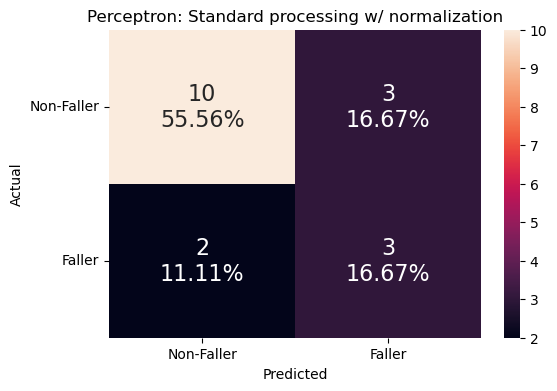

              precision    recall  f1-score   support

      Faller       0.50      0.60      0.55         5
  Non-Faller       0.83      0.77      0.80        13

    accuracy                           0.72        18
   macro avg       0.67      0.68      0.67        18
weighted avg       0.74      0.72      0.73        18



In [260]:
classes = ['Non-Faller', 'Faller']
cm_python = confusion_matrix(y_true=y_test_label, y_pred=y_pred_label, labels=classes)

plt.subplots(figsize=(6,4))

group_counts = ['{0:0.0f}'.format(value) for value in
                cm_python.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cm_python.flatten()/np.sum(cm_python)]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
df_cm_python = pd.DataFrame(cm_python)

sns.heatmap(df_cm_python, annot=labels, fmt='',annot_kws={"size": 16}, xticklabels=classes, yticklabels=classes) # font size
plt.title('Perceptron: Standard processing w/ normalization')
plt.xlabel('Predicted')
plt.ylabel('Actual') 
plt.yticks(rotation=0)
plt.show()

print(classification_report(y_true=y_test_label, y_pred=y_pred_label))